In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import json
from datetime import datetime,timedelta
from collections import Counter
from functools import partial
import copy
import scipy.stats
import random
import seaborn as sns
from py2neo import Graph
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
import os
pd.set_option("display.max_columns",50)
%matplotlib inline

In [44]:
def riqi_ftime(df):
    df.insert(1,'riqi',df.ftime.map(lambda x: x.split(' ')[0]))
    df.insert(2,'fftime',df.ftime.map(lambda x: x.split(' ')[1]))
    df.drop('ftime',axis=1,inplace=True)
    df.fftime=df.fftime.map(lambda x: x.split(':')[0]+':'+x.split(':')[1])
    df.fftime=df.fftime.map(lambda x: timesplit(x))
    return df

def timesplit(input:str,sep=':',gra="15"):
    h,m=input.split(sep)
    m=int(m)
    if gra=="10":
        if m<10:
            m_str='00'
        elif m<20:
            m_str='10'
        elif m<30:
            m_str='20'
        elif m<40:
            m_str='30'
        elif m<50:
            m_str='40'
        else:
            m_str='50'
    elif gra=="15":
        if m<15:
            m_str='00'
        elif m<30:
            m_str='15'
        elif m<45:
            m_str='30'
        else:
            m_str='45'
    return h+':'+m_str

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p,M)+0.5*scipy.stats.entropy(q, M)


## Data preparation and processing

In [88]:
#读取历史数据和生成数据 
trip_df_generate_raw = pd.read_csv("./data/generate_sj_path_tt.csv",encoding='utf-8') # the generated data
trip_df_history_raw = pd.read_csv("./data/raw_sj.csv",encoding='utf-8') # the original data
trip_df_history_raw = trip_df_history_raw.drop('riqi',axis =1)
trip_df_history=riqi_ftime(trip_df_history_raw)
trip_df_generate = riqi_ftime(trip_df_generate_raw)

In [89]:
# split data by weekday and holiday; weekday: 12-16，holiday: 17-18
trip_df_g = trip_df_generate.query("'2019-08-12'<=riqi<='2019-08-16'") 
trip_df_h = trip_df_history.query("'2019-08-12'<=riqi<='2019-08-16'")
trip_df_h.columns = ['hphm','riqi','fftime','fpark','tpark','path','route','traveltime'] 
## holiday
# trip_df_g = trip_df_generate.query("riqi=='2019-08-17' or riqi == '2019-08-18'")
# trip_df_h = trip_df_history.query("riqi=='2019-08-17' or riqi == '2019-08-18'")
# trip_df_h.columns = ['hphm','riqi','fftime','fpark','tpark','path','route','traveltime'] 
## Distinguishing time periods (fine-grained)
# trip_df_g = trip_df_generate.query("'17:00'<=fftime<='18:30'") 
# trip_df_h = trip_df_history.query("'17:00'<=fftime<='18:30'")

In [6]:
trip_df_g

,hphm,riqi,fftime,fpark,tpark,path,traveltime
0,皖P2350384,2019-08-12,16:30,P122,P165,30097-30096-30101-30106-30103-30028-30092-3002...,18.41
1,皖P2350384,2019-08-13,06:00,P165,P122,8008-1025-1026-1054-1053-8004-8005-8005-8004-1...,27.36
2,皖P2350384,2019-08-13,16:30,P122,P165,30097-30096-30101-30112-30104-30028-30092-3002...,16.38
3,皖P2350384,2019-08-13,18:30,P165,P119,21220-8009-1047-8008-8008-1214-21207,9.23
4,皖P2350384,2019-08-14,05:45,P119,P122,1215-1214-1047-1220-1222-1221-21184-21185-2118...,25.95
...,...,...,...,...,...,...,...
211317,皖A2100404,2019-08-13,15:00,P1,P119,21188-21187-21186-21185-21184-1221-1222-1220-1...,12.00
211318,皖A2100404,2019-08-14,07:45,P119,P344,21207-1215-1217-1216-1130-15363-21245-30062-30024,15.52
211319,皖A2100404,2019-08-15,06:30,P344,P119,30024-30062-21245-15363-1045-1045-1130-1216-12...,15.29
211320,皖A2100404,2019-08-16,06:30,P119,P389,1215-1217-1216-1130-15363-21245-30062-30024-30...,15.48


## 出行时间模式测试

In [76]:
t_zhen=dict(Counter(trip_df_h.fftime))
t_zhen_g=dict(Counter(trip_df_g.fftime))
t_zhen=sorted(t_zhen.items(),key=lambda x:x[0])
t_zhen_g=sorted(t_zhen_g.items(),key=lambda x:x[0])
x=[(datetime.strptime(i[0],"%H:%M")-datetime(1900,1,1,0,0)).seconds/60 for i in t_zhen]
x=np.asarray(x)
y=np.asarray([i[1] for i in t_zhen])
y_g=np.asarray([i[1] for i in t_zhen_g])
print(x)
print(y_g)


[390. 405. 420. 435. 450. 465. 480. 495. 510.]
[3302 4094 5565 7089 8450 7035 5117 3647 2786]


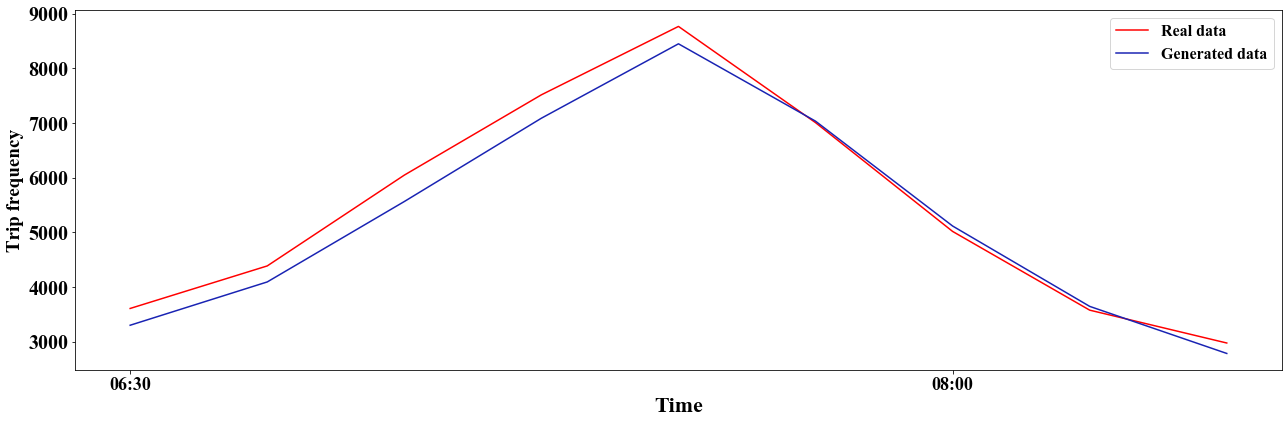

In [77]:
fig1,ax1=plt.subplots(1,1,figsize=(18,6))

x_tick=list(set(trip_df_h.fftime))
x_tick=sorted(x_tick)[::6]

ax1.plot([i[0] for i in t_zhen],[i[1] for i in t_zhen],label='Real data',color='r')
ax1.plot([i[0] for i in t_zhen],[i[1] for i in t_zhen_g],label='Generated data',color='#1923b3')
# ax1.set_title("通勤者者单周出行时间分布-周中",size=28)
ax1.set_ylabel('Trip frequency', fontproperties='Times New Roman',size=19)
ax1.set_xlabel('Time',fontproperties='Times New Roman',size=22)
plt.legend(prop={'family' : 'Times New Roman',"size":16})
plt.xticks(x_tick,fontproperties='Times New Roman', size=18)
plt.yticks(fontproperties='Times New Roman', size=20)
plt.tight_layout()
# plt.savefig('./fig/passby_holiday.pdf')

### Calculate JS dispersion

In [273]:
print(JS_divergence(y,y_g))

0.00020494959339165586


## 空间模式测试

### Hotness of traffic zone with top-k

In [117]:
OD_park_k = 50 # set "k" of top-k
# trip destination traffic zone counting of the real data
real_tpark = Counter(trip_df_h.tpark)
real_ftpark  = sorted(real_tpark.items(),key=lambda x:x[1],reverse=True)
print('the number of traffic zones:',len(real_ftpark))
top_real_ftpark = [i[0] for i in real_ftpark[:OD_park_k]] 
 # trip destination traffic zone counting of the generated data
generate_tpark = Counter(trip_df_g.tpark)
generate_ftpark  = sorted(generate_tpark.items(),key=lambda x:x[1],reverse=True)
top_generate_ftpark = [i[0] for i in generate_ftpark[:OD_park_k]] 
print('overlap number:',len(set(top_generate_ftpark)&set(top_real_ftpark)))
print('overlap ratio:',len(set(top_generate_ftpark)&set(top_real_ftpark))/OD_park_k)

共有小区数： 207
重合的小区个数为: 45
重合率为: 0.9


### top-N DO组合重合度（Top-N generate vs his）

In [90]:
trip_df_h.insert(4,'od',trip_df_h.fpark+'-'+trip_df_h.tpark)
trip_df_g.insert(4,'od',trip_df_g.fpark+'-'+trip_df_g.tpark)

In [91]:
#确定对比的TOP-N
OD_pair_N = 143 # 此处设置对比top？，若对比top-N，更改500为N
# 获取历史出行数据的OD小区选择数据，dtype：Counter[park:trip_num]
real_od=Counter(trip_df_h.od)
real_od = sorted(real_od.items(),key=lambda x:x[1],reverse=True)
print('共有OD对:',len(real_od))
generate_od = Counter(trip_df_g.od)
generate_od = sorted(generate_od.items(),key=lambda x:x[1],reverse=True)
top_real_od = [i[0] for i in real_od[:OD_pair_N]]
top_generate_od = [i[0] for i in generate_od[:OD_pair_N]]
print('重合的OD对个数为:',len(set(top_generate_od)&set(top_real_od)))
print('重合率为:', len(set(top_generate_od)&set(top_real_od))/OD_pair_N)


共有OD对: 26646
重合的OD对个数为: 107
重合率为: 0.7482517482517482


## 路段流量测试

In [92]:
trip_df_g.loc[:,'path']=trip_df_g.path.map(lambda x:x.split('-'))
trip_df_h.loc[:,'path']=trip_df_h.path.map(lambda x:x.split('-'))

c:\Users\LiGuilong\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [93]:
trip_df_h

,hphm,riqi,fftime,fpark,od,tpark,path,route,traveltime
0,黑Y2309224,2019-08-12,08:15,P155,P155-P145,P145,"[21206, 21236]",4438-4474-4448,6.0
1,黑Y2309224,2019-08-14,11:30,P145,P145-P145,P145,"[21139, 21230]",4582-4518-4496,6.0
2,黑Y2309224,2019-08-14,12:15,P107,P107-P88,P88,"[8009, 1027]",4624-4650-4708,6.0
3,黑Y2309224,2019-08-15,05:15,P147,P147-P147,P147,"[15342, 15342]",4562-4493-4562,6.0
4,黑Y2309224,2019-08-15,06:30,P142,P142-P147,P147,"[21215, 21242]",4423-4471-4440,6.0
...,...,...,...,...,...,...,...,...,...
1053706,#P1893030,2019-08-12,15:45,P11,P11-P11,P11,"[21215, 21216]",4471-4423-4393,6.0
1053707,#P1893030,2019-08-16,17:15,P11,P11-P11,P11,"[21215, 21216]",4471-4423-4393,6.0
1053708,#P1840756,2019-08-12,14:30,P11,P11-P11,P11,"[21215, 21216]",4471-4423-4393,6.0
1053709,#P1840756,2019-08-12,16:15,P11,P11-P11,P11,"[21215, 21216]",4471-4423-4393,6.0


In [94]:
trip_df_morning=trip_df_h
trip_df_morning_g=trip_df_g

In [95]:
trip_df_morning_g

,hphm,riqi,fftime,fpark,od,tpark,path,traveltime
0,皖P3133933,2019-08-12,13:30,P72,P72-P123,P123,"[1127, 1041, 1040, 1034, 1042, 1216, 1217, 105...",27.71
1,皖P3133933,2019-08-12,14:00,P123,P123-P176,P176,"[1056, 1025, 8008, 21203, 21225, 21208, 21231,...",29.68
2,皖P3133933,2019-08-12,15:15,P160,P160-P105,P105,"[1040, 1041, 1015]",5.80
3,皖P3133933,2019-08-12,17:45,P105,P105-P162,P162,"[1015, 1037]",6.00
4,皖P3133933,2019-08-12,18:15,P162,P162-P96,P96,"[1043, 1040, 1034, 8005, 8004, 1053]",10.05
...,...,...,...,...,...,...,...,...
1064473,皖P2267123,2019-08-15,10:00,P344,P344-P46,P46,"[30024, 30062, 21245, 15363, 1130, 1216, 1217,...",24.22
1064474,皖P2267123,2019-08-17,19:45,P46,P46-P64,P64,"[21143, 8523, 21144, 1206, 1234, 8510, 1230, 1...",16.40
1064475,皖P2009151,2019-08-12,07:00,P154,P154-P2,P2,"[1048, 1131, 1130, 15342, 21214, 21231, 21231,...",14.66
1064476,皖P2009151,2019-08-14,10:00,P2,P2-P154,P154,"[21216, 21215, 21242, 21242, 21214, 15342, 113...",10.17


In [96]:
flow_list = []
flow_list_g = []
for row in trip_df_morning.path:
    flow_list.extend(row)
counter_flow=Counter(flow_list)
dict_flow = dict(counter_flow)
sorted_flow = sorted(dict_flow.items(),key=lambda x:x[1],reverse=True)
top_flow=sorted_flow[:100]
top_flow_dict=dict(top_flow)
# print(top_flow)
# print(sum([i[1] for i in top_flow]))

for row in trip_df_morning_g.path:
    flow_list_g.extend(row)
counter_flow_g=Counter(flow_list_g)
dict_flow_g = dict(counter_flow_g)
top_flow_g_dict = {k:dict_flow_g[k] for k in top_flow_dict}
# sorted_flow_g = sorted(dict_flow_g.items(),key=lambda x:x[1],reverse=True)
# top_flow_g=sorted_flow_g[:100]
# top_flow_g_dict=dict(top_flow_g)
# # print(top_flow_g)
# public_road=top_flow_dict.keys()&top_flow_g_dict.keys()
# print(len(public_road))

In [97]:
len(sorted_flow)

448

In [98]:
x_ticks_flow = top_flow_dict.keys()
y_flow = np.asarray(list(top_flow_dict.values()))
y_flow = y_flow/sum(y_flow)
y_flow_g = np.asarray(list(top_flow_g_dict.values()))
y_flow_g = y_flow_g/sum(y_flow_g)

[-0.02, -0.015, -0.01, -0.005, 0.0, 0.005, 0.01, 0.015, 0.02, 0.025]


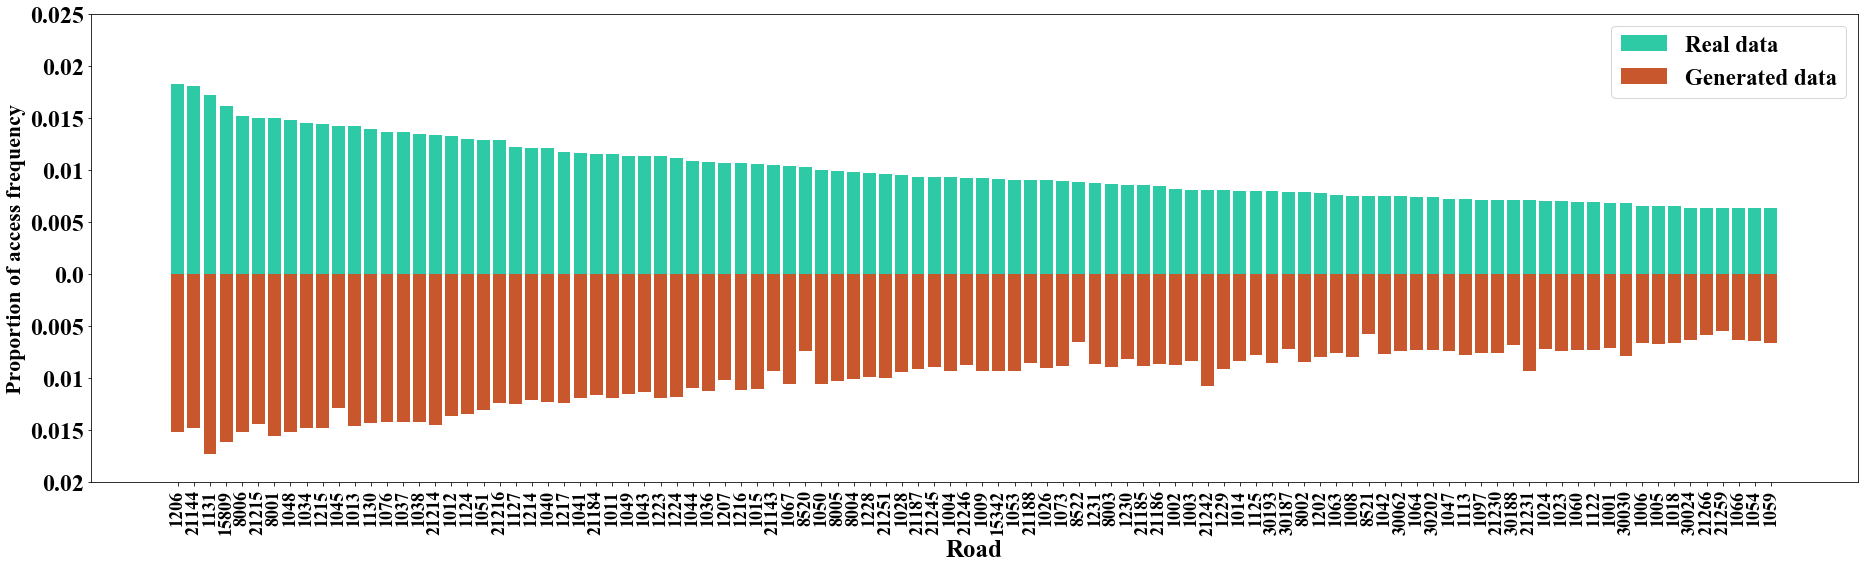

In [99]:
fig_flow,ax_flow = plt.subplots(1,1,figsize=(26,8))
ax_flow.bar(x_ticks_flow,y_flow,label='Real data',color ='#2ec9a5')
ax_flow.bar(x_ticks_flow,-y_flow_g,label='Generated data',color = '#c9572e')
# ax_flow.plot(np.arange(len(public_road)),[-0.005]*100,color ='black')
plt.legend(prop={'family' : 'Times New Roman',"size":23})
plt.xticks(rotation=90)

plt.ylim([-0.02,0.025])
# plt.ylim([-0.04,0.04])
y_flow_ticks = list(ax_flow.get_yticks())
y_flow_ticks = [round(i,3) for i in y_flow_ticks]
plt.yticks(ax_flow.get_yticks(),np.array([abs(i) for i in y_flow_ticks]))
ax_flow.set_ylabel('Proportion of access frequency', fontproperties='Times New Roman',size=22)
ax_flow.set_xlabel('Road',fontproperties='Times New Roman',size=25)
plt.xticks(fontproperties='Times New Roman', size=18)
plt.yticks(fontproperties='Times New Roman', size=24)
# plt.xlim([-0.0025,0.0025])
print(y_flow_ticks)
plt.tight_layout()
plt.savefig('./fig/flow_pro_sj.pdf')
plt.show()


In [140]:
print(JS_divergence(y_flow,y_flow_g))

0.0015597392402024578


## 空间连续性测试

In [127]:
def trip_continuity_test(input_df:pd.DataFrame):
    max_num = len(input_df)
    tol_count = 0
    continuous = 0
    input_df = input_df.sort_values(by=['hphm','riqi','fftime'], ascending=(False, True, True))  # dataframe多重排序,第一列优先级高
    input_df.reset_index(drop=True, inplace=True)
    for index,row in input_df.iterrows():
        if index == max_num - 1:
            break
        if row['hphm'] == input_df.iloc[index + 1, 0]:
            tol_count += 1
            fpark = input_df.iloc[index + 1].fpark
            tpark = row.tpark
            if fpark == tpark:
                continuous+=1
            if index%1000 == 0:
                print('tol:', tol_count/max_num,'con:',continuous/tol_count)
            
trip_continuity_test(trip_df_g)

tol: 4.528185691838851e-06 con: 0.0
tol: 0.0014535476070802712 con: 0.40809968847352024
tol: 0.007005103265274703 con: 0.3749191984486102
tol: 0.008698644714022433 con: 0.3862571577303488
tol: 0.016541462332287322 con: 0.4054202025732275
tol: 0.03378932163250151 con: 0.38367729831144465
tol: 0.04283210845910369 con: 0.384395813510942
tol: 0.045141483161941505 con: 0.3856956565352593
tol: 0.049443259569188415 con: 0.3822694385932778
tol: 0.05585517050883223 con: 0.38378597486826105
tol: 0.05812379154044349 con: 0.38617949516983485
tol: 0.06040599712913027 con: 0.38808095952023985
tol: 0.06263386448951498 con: 0.3884470792365529
tol: 0.07158155941658856 con: 0.3910045546558704
tol: 0.084944235393205 con: 0.3944240098086252
tol: 0.08726719465311833 con: 0.3954441677044417
tol: 0.08959921028441534 con: 0.3958154343761055
tol: 0.09181349308772455 con: 0.3974156638390215
tol: 0.10077930075756547 con: 0.4011053199137311
tol: 0.10953228369988996 con: 0.4039026003555335
tol: 0.11286050018339153

## 个体级的测试

In [3]:
indi_raw_df = pd.read_csv("./data/raw_data_0801_0902.csv")[["hphm_new", "ftime","fpark", "tpark"]]

In [18]:
len(indi_raw_df)    

9002572

In [144]:
trip_df_gen_tq = pd.read_csv("./data/scitific_data_tq.csv",encoding='utf-8')
trip_df_gen_wd = pd.read_csv("./data/scitific_data_wd.csv",encoding='utf-8')
trip_df_gen_sj = pd.read_csv("./data/scitific_data_sj.csv",encoding='utf-8')
trip_df_gen_gp = pd.read_csv("./data/scitific_data_gppp.csv",encoding='utf-8')
trip_df_gen_glc = pd.read_csv("./data/scitific_data_glc.csv",encoding='utf-8')


### 个体空间活动范围

In [219]:
def spa_range(df):
    coin_list = []
    veh_list = list(df.hphm.unique())
    sub_df_ori = indi_raw_df.query(f"hphm_new in {veh_list}")[['hphm_new','fpark','tpark']]
    for veh in veh_list: 
        sub_df = sub_df_ori.query(f"hphm_new=='{veh}'")[['fpark','tpark']]
        sub_df_g = df.query(f"hphm=='{veh}'")[['fpark','tpark']]
        park_raw = dict(Counter(sub_df.tpark))
        park_gen = dict(Counter(sub_df_g.tpark))
        park_raw = set(list(park_raw.keys()))
        park_gen = set(list(park_gen.keys()))
        if len(park_raw)==0:
            continue
        coin = len(park_raw&park_gen)/len(park_raw)
        coin_list.append(round(coin,2))
    return coin_list

In [214]:
coin_list_tq = spa_range(trip_df_gen_tq)


In [220]:
coin_list_wd = spa_range(trip_df_gen_wd)
coin_list_sj = spa_range(trip_df_gen_sj)
coin_list_gp = spa_range(trip_df_gen_gp)
coin_list_glc = spa_range(trip_df_gen_glc)

In [228]:
coin_list_glc1 = [i for i in coin_list_glc if i > 0]

0.2

In [229]:
ran_spa_tol = []
ran_spa_tol.extend(coin_list_tq)
ran_spa_tol.extend(coin_list_wd)
ran_spa_tol.extend(coin_list_sj)
ran_spa_tol.extend(coin_list_gp)
ran_spa_tol.extend(coin_list_glc1)

spa_tol_type = []
spa_tol_type.extend(['Commuter']*len(coin_list_tq))
spa_tol_type.extend(['Stable traveler']*len(coin_list_wd))
spa_tol_type.extend(['Random traveler']*len(coin_list_sj))
spa_tol_type.extend(['High-fre traveler']*len(coin_list_gp))
spa_tol_type.extend(['Passby traveler']*len(coin_list_glc1))

stat_spa_df = pd.DataFrame({'veh_type':spa_tol_type,"spa_ran":ran_spa_tol})

No handles with labels found to put in legend.


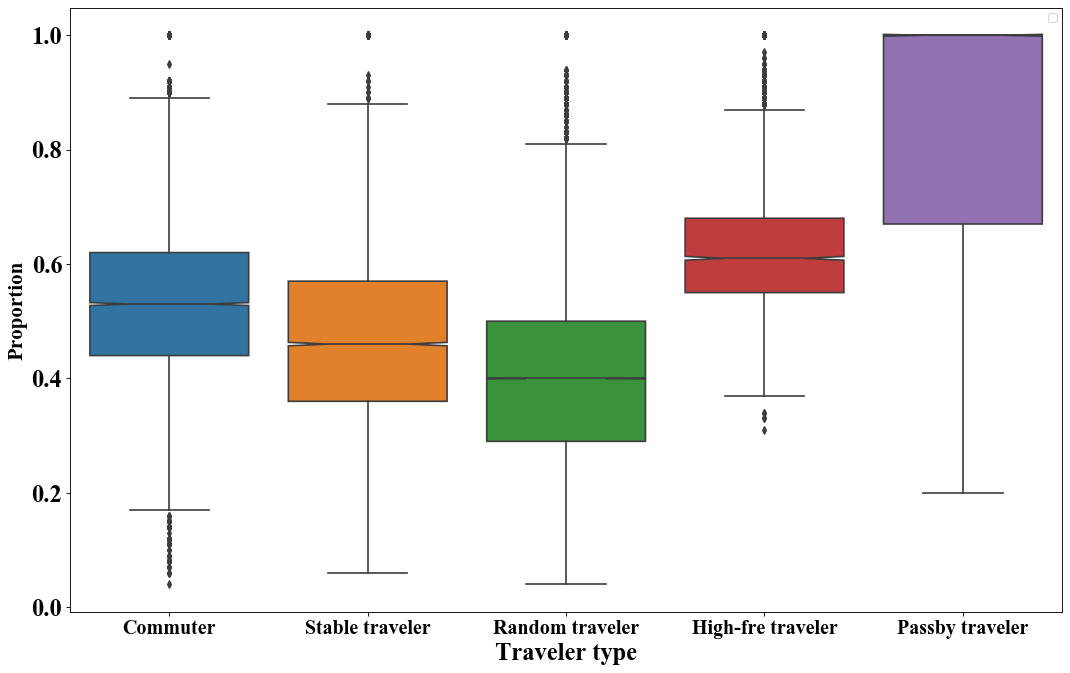

In [232]:
fig2,ax2=plt.subplots(1,1,figsize=(16,10),dpi= 80)
label1 = ['Commuter','Stable traveler','Random traveler','High-fre traveler','Passby traveler']
sns.boxplot(x='veh_type',y='spa_ran',data=stat_spa_df, notch=True)
plt.xticks(fontproperties='Times New Roman', size=18)
plt.yticks(fontproperties='Times New Roman', size=22)
ax2.set_ylabel('Proportion', fontproperties='Times New Roman',size=19)
ax2.set_xlabel('Traveler type', fontproperties='Times New Roman',size=22)
plt.savefig('./fig/spa_ran_fre.pdf')
# plt.title('Density Plot of City Mileage by n_Cylinders', fontsize=22)
plt.legend()
plt.show()

### 出行时间范围

In [6]:
indi_raw_df

,hphm_new,ftime,fpark,tpark
0,黑Z3138261,2019-08-03 07:40:24,P89,P100
1,黑Z3138261,2019-08-05 17:11:52,P70,P126
2,黑Z3138261,2019-08-06 14:14:00,P89,P100
3,黑Z3138261,2019-08-09 14:05:45,P70,P70
4,黑Z3138261,2019-08-10 09:31:52,P70,P126
...,...,...,...,...
9002567,##2804911,2019-08-11 16:31:16,P11,P11
9002568,##2804911,2019-08-23 13:53:42,P11,P11
9002569,##2733992,2019-08-16 03:19:10,P142,P595
9002570,##2715548,2019-08-18 16:15:56,P142,P595


In [9]:
def judge_week_time_slot(time):  # 根据时间判断时段 present=1时更改实例属性
        time_morpeak_start = "06:30"
        time_morpeak_end = "08:30"
        time_ant_end = "13:30"
        time_noon_end = "14:30"
        time_even_peak_start = "17:00"
        time_even_peak_end = "18:30"
        time_even_ping = "22:30"
        if time >= time_morpeak_start and time < time_morpeak_end:
            shiduan = "早高峰"  # 修改时段属性
        elif time >= time_morpeak_end and time < time_ant_end:
            shiduan = "上午平峰"
        elif time >= time_ant_end and time < time_noon_end:
            shiduan = "午高峰"
        elif time >= time_noon_end and time < time_even_peak_start:
            shiduan = "下午平峰"
        elif time >= time_even_peak_start and time < time_even_peak_end:
            shiduan = "晚高峰"
        elif time >= time_even_peak_end and time < time_even_ping:
            shiduan = "晚平峰"
        else:
            shiduan = "夜间"
        return shiduan 
    
def riqi_ftime_tem(df):
    df.insert(1,'riqi',df.ftime.map(lambda x: x.split(' ')[0]))
    df.insert(2,'fftime',df.ftime.map(lambda x: x.split(' ')[1]))
    df.drop('ftime',axis=1,inplace=True)
    df.fftime=df.fftime.map(lambda x: x.split(':')[0]+':'+x.split(':')[1])
    df.fftime=df.fftime.map(lambda x: judge_week_time_slot(x))
    return df

def tem_range(df):
    coin_list = []
    veh_list = list(df.hphm.unique())
    sub_df_ori = tem_trip_raw.query(f"hphm_new in {veh_list}")[['hphm_new','fftime']]
    for veh in veh_list: 
        sub_df = sub_df_ori.query(f"hphm_new=='{veh}'")
        sub_df_g = df.query(f"hphm=='{veh}'")[['hphm','fftime']]
        park_raw = dict(Counter(sub_df.fftime))
        park_gen = dict(Counter(sub_df_g.fftime))
        park_raw = set(list(park_raw.keys()))
        park_gen = set(list(park_gen.keys()))
        if len(park_raw)==0:
            continue
        coin = len(park_raw&park_gen)/len(park_raw|park_gen)
        coin_list.append(round(coin,2))
    return coin_list

In [8]:
tem_trip_raw = riqi_ftime_tem(indi_raw_df)
tem_trip_tq = riqi_ftime_tem(trip_df_gen_tq)
tem_trip_wd = riqi_ftime_tem(trip_df_gen_wd)
tem_trip_sj = riqi_ftime_tem(trip_df_gen_sj)
tem_trip_gp = riqi_ftime_tem(trip_df_gen_gp)
tem_trip_glc = riqi_ftime_tem(trip_df_gen_glc)

In [9]:
tem_tq = tem_range(tem_trip_tq)
tem_wd = tem_range(tem_trip_wd)
tem_sj = tem_range(tem_trip_sj)
tem_gp = tem_range(tem_trip_gp)
tem_glc = tem_range(tem_trip_glc)

In [10]:
tem_tq

[0.57,
 0.71,
 0.5,
 0.83,
 0.43,
 0.43,
 0.29,
 0.5,
 0.5,
 0.71,
 0.33,
 0.71,
 0.5,
 0.43,
 0.6,
 0.57,
 0.71,
 1.0,
 0.33,
 0.5,
 1.0,
 0.71,
 0.29,
 0.43,
 0.71,
 0.83,
 0.8,
 0.71,
 0.5,
 0.57,
 0.57,
 0.67,
 0.71,
 0.5,
 0.86,
 0.71,
 0.71,
 0.71,
 0.17,
 0.67,
 0.71,
 0.71,
 0.5,
 0.83,
 0.57,
 1.0,
 0.86,
 0.6,
 0.71,
 0.83,
 0.71,
 0.83,
 0.83,
 0.43,
 0.86,
 0.71,
 0.6,
 0.86,
 0.86,
 0.71,
 0.57,
 0.71,
 0.71,
 0.6,
 0.86,
 0.4,
 1.0,
 0.71,
 0.5,
 0.83,
 0.71,
 0.5,
 0.67,
 0.8,
 0.67,
 0.57,
 1.0,
 0.83,
 0.57,
 0.17,
 1.0,
 0.83,
 0.71,
 0.71,
 0.67,
 0.71,
 0.86,
 1.0,
 0.86,
 0.86,
 0.5,
 0.83,
 0.57,
 0.67,
 0.71,
 0.57,
 0.83,
 0.86,
 1.0,
 1.0,
 0.71,
 0.57,
 0.86,
 0.71,
 0.71,
 0.83,
 0.8,
 0.83,
 0.57,
 0.67,
 0.57,
 0.86,
 0.6,
 0.43,
 0.67,
 1.0,
 0.83,
 1.0,
 0.86,
 0.71,
 1.0,
 0.6,
 0.86,
 0.83,
 1.0,
 0.86,
 0.67,
 0.86,
 0.57,
 0.67,
 0.5,
 0.86,
 0.86,
 0.83,
 0.67,
 0.83,
 0.8,
 0.8,
 0.57,
 0.6,
 1.0,
 0.67,
 0.71,
 0.71,
 0.83,
 0.86,
 0.71,
 0.83,
 0.

In [12]:
ran_tem_tol = []
ran_tem_tol.extend(tem_tq)
ran_tem_tol.extend(tem_wd)
ran_tem_tol.extend(tem_sj)
ran_tem_tol.extend(tem_gp)
ran_tem_tol.extend(tem_glc)

tem_tol_type = []
tem_tol_type.extend(['Commuter']*len(tem_tq))
tem_tol_type.extend(['Stable traveler']*len(tem_wd))
tem_tol_type.extend(['Random traveler']*len(tem_sj))
tem_tol_type.extend(['High-fre traveler']*len(tem_gp))
tem_tol_type.extend(['Passby traveler']*len(tem_glc))

stat_tem_df = pd.DataFrame({'veh_type':tem_tol_type,"spa_ran":ran_tem_tol})

No handles with labels found to put in legend.


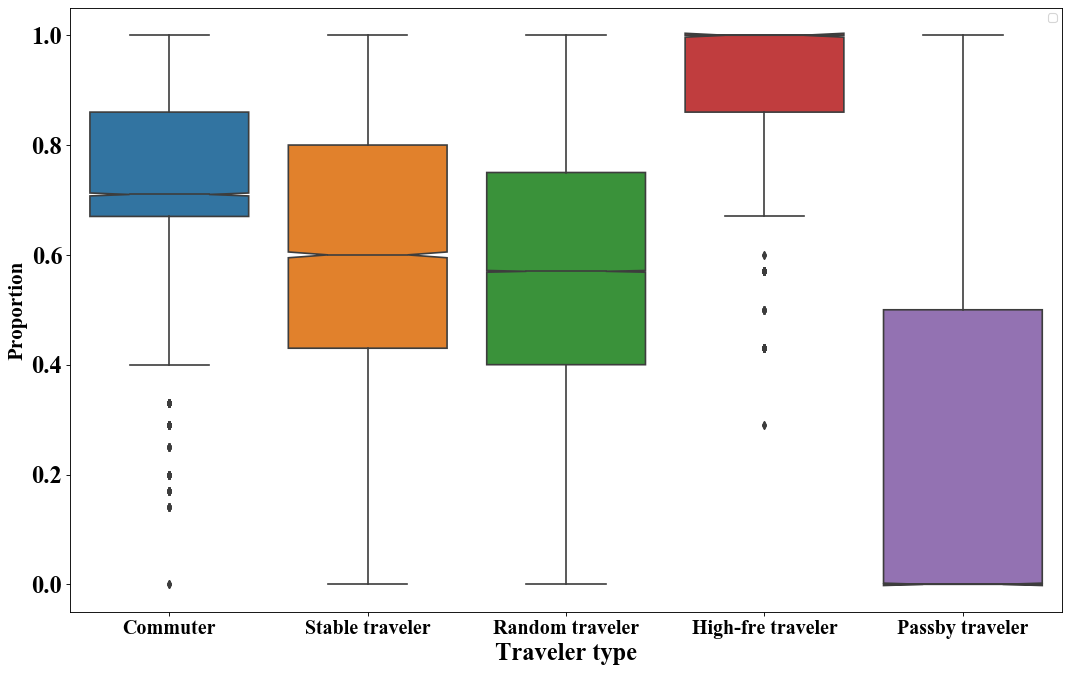

In [15]:
fig3,ax3=plt.subplots(1,1,figsize=(16,10),dpi= 80)
label1 = ['Commuter','Stable traveler','Random traveler','High-fre traveler','Passby traveler']
sns.boxplot(x='veh_type',y='spa_ran',data=stat_tem_df, notch=True)
plt.xticks(fontproperties='Times New Roman', size=18)
plt.yticks(fontproperties='Times New Roman', size=22)
ax3.set_ylabel('Proportion', fontproperties='Times New Roman',size=19)
ax3.set_xlabel('Traveler type', fontproperties='Times New Roman',size=22)
plt.savefig('./fig/tem_ran_fre.pdf')
# plt.title('Density Plot of City Mileage by n_Cylinders', fontsize=22)
plt.legend()
plt.show()

In [19]:
trip_gj_gen_tq = pd.read_csv("./data/generate_tq_path_tt.csv",encoding='utf-8')
trip_gj_gen_wd = pd.read_csv("./data/generate_wd_path_tt.csv",encoding='utf-8')
trip_gj_gen_sj = pd.read_csv("./data/generate_sj_path_tt.csv",encoding='utf-8')
trip_gj_gen_gp = pd.read_csv("./data/generate_gp_path_tt.csv",encoding='utf-8')
trip_gj_gen_glc = pd.read_csv("./data/generate_glc_path_tt.csv",encoding='utf-8')

In [21]:
# 将各个类型出行者的出行数据合并起来
trip_tol = pd.concat([trip_gj_gen_tq,trip_gj_gen_wd,trip_gj_gen_sj,trip_gj_gen_gp,trip_gj_gen_glc],ignore_index=True)

In [22]:
# 将时间拆成date 和 departure time 两个字段
trip_tol.insert(1,'date',trip_tol.ftime.map(lambda x:x.split()[0]))
trip_tol.insert(2,'departure',trip_tol.ftime.map(lambda x:x.split()[1]))
trip_tol = trip_tol.drop('ftime',axis=1)

In [29]:
veh_type_forisner = []
veh_type_forisner.extend(['Commuter']*len(trip_gj_gen_tq))
veh_type_forisner.extend(['Stable traveler']*len(trip_gj_gen_wd))
veh_type_forisner.extend(['Random traveler']*len(trip_gj_gen_sj))
veh_type_forisner.extend(['High-fre traveler']*len(trip_gj_gen_gp))
veh_type_forisner.extend(['Passby traveler']*len(trip_gj_gen_glc))

In [30]:
#增加traveler type 字段
trip_tol.insert(1,'traveler_type',veh_type_forisner)

In [32]:
trip_tol.to_csv("./data/generated_data_tem.csv",index=False)

In [170]:
trip_tol = pd.read_csv("./data/generated_data_submit.csv")

In [171]:
trip_tol

,hphm,traveler_type,date,departure,fpark,tpark,path,traveltime
0,Wan_P2350384,Commuter,2019-08-12,16:30:00,P122,P165,30097-30096-30101-30106-30103-30028-30092-3002...,18.41
1,Wan_P2350384,Commuter,2019-08-13,06:06:00,P165,P122,8008-1025-1026-1054-1053-8004-8005-8005-8004-1...,27.36
2,Wan_P2350384,Commuter,2019-08-13,16:39:00,P122,P165,30097-30096-30101-30112-30104-30028-30092-3002...,16.38
3,Wan_P2350384,Commuter,2019-08-13,18:30:00,P165,P119,21220-8009-1047-8008-8008-1214-21207,9.23
4,Wan_P2350384,Commuter,2019-08-14,05:45:00,P119,P122,1215-1214-1047-1220-1222-1221-21184-21185-2118...,25.95
...,...,...,...,...,...,...,...,...
1829213,Wan_P1891926,Passby traveler,2019-08-14,08:54:00,P96,P160,1042-1014,6.00
1829214,Wan_P1891926,Passby traveler,2019-08-15,09:36:00,P96,P160,8005-1034,6.00
1829215,Wan_P2118926,Passby traveler,2019-08-16,16:06:00,P178,P178,1002-1005,6.00
1829216,Wan_P3435705,Passby traveler,2019-08-17,09:56:00,P96,P160,8005-1034,6.00


In [43]:
from torch import sort


def process_time(depar_time:str):
    """Morning_peak, Morning_flat, Noon_peak, Noon_flat, Evening_peak, Evening_flat, Night"""
    h, m, s = depar_time.split(":")
    time = h+':'+m
    time_morpeak_start = "06:30"
    time_morpeak_end = "08:30"
    time_ant_end = "13:30"
    time_noon_end = "14:30"
    time_even_peak_start = "17:00"
    time_even_peak_end = "18:30"
    time_even_ping = "22:30"
    if time >= time_morpeak_start and time < time_morpeak_end:
        shiduan = "Morning_peak"  # 修改时段属性
    elif time >= time_morpeak_end and time < time_ant_end:
        shiduan = "Morning_flat"
    elif time >= time_ant_end and time < time_noon_end:
        shiduan = "Noon_peak"
    elif time >= time_noon_end and time < time_even_peak_start:
        shiduan = "Noon_flat"
    elif time >= time_even_peak_start and time < time_even_peak_end:
        shiduan = "Evening_peak"
    elif time >= time_even_peak_end and time < time_even_ping:
        shiduan = "Evening_flat"
    else:
        shiduan = "Night"
    return time,shiduan
    
    
def make_json_f_sd( in_df:pd.DataFrame):
    tol_dict = {'veh':[],"sd":[]}
    v_list = list(set(in_df.hphm))
    for i in v_list:
        sub_df = in_df.query(f"hphm == '{i}'")
        sub_list = list(set(sub_df.fftime))
        tol_dict['veh'].append(i)
        tol_dict['sd'].append(len(sub_list))
    return tol_dict    

def sd_combining_forplot(in_list:list):
    dic_in = dict(Counter(in_list))
    sum_val = sum(dic_in.values())
    dic_in = {k:v/sum_val for k,v in dic_in.items()}
    dic_in = {i:round(dic_in[i],3) if i in dic_in else 0 for i in range(1,8)}
    # dic_in = sorted(dic_in.items(),key=lambda x:x[0],reverse=False)
    return dic_in
    
    
    

In [135]:
round(1.2,2)

1.2

In [173]:
de_time_list = []
shiduan_list = []
for i,t in enumerate(trip_tol.departure):
    time,sd = process_time(t)
    de_time_list.append(time)
    shiduan_list.append(sd)
    if i%100 == 0 :
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [174]:
trip_tol.departure = de_time_list
trip_tol.insert(4,'Time_slot',shiduan_list)

In [175]:
trip_tol

,hphm,traveler_type,date,departure,Time_slot,fpark,tpark,path,traveltime
0,Wan_P2350384,Commuter,2019-08-12,16:30,Noon_flat,P122,P165,30097-30096-30101-30106-30103-30028-30092-3002...,18.41
1,Wan_P2350384,Commuter,2019-08-13,06:06,Night,P165,P122,8008-1025-1026-1054-1053-8004-8005-8005-8004-1...,27.36
2,Wan_P2350384,Commuter,2019-08-13,16:39,Noon_flat,P122,P165,30097-30096-30101-30112-30104-30028-30092-3002...,16.38
3,Wan_P2350384,Commuter,2019-08-13,18:30,Evening_flat,P165,P119,21220-8009-1047-8008-8008-1214-21207,9.23
4,Wan_P2350384,Commuter,2019-08-14,05:45,Night,P119,P122,1215-1214-1047-1220-1222-1221-21184-21185-2118...,25.95
...,...,...,...,...,...,...,...,...,...
1829213,Wan_P1891926,Passby traveler,2019-08-14,08:54,Morning_flat,P96,P160,1042-1014,6.00
1829214,Wan_P1891926,Passby traveler,2019-08-15,09:36,Morning_flat,P96,P160,8005-1034,6.00
1829215,Wan_P2118926,Passby traveler,2019-08-16,16:06,Noon_flat,P178,P178,1002-1005,6.00
1829216,Wan_P3435705,Passby traveler,2019-08-17,09:56,Morning_flat,P96,P160,8005-1034,6.00


In [ ]:
trip_tol.to_csv("./data/generated_data_submit_new.csv",index = False)

### 出行时间的组合分析

In [123]:
trip_df_g_f_sd = trip_df_g 
trip_df_g_f_sd.fftime = trip_df_g.fftime.map(lambda x: judge_week_time_slot(x))
# trip_df_h
trip_df_h_f_sd = trip_df_h 
trip_df_h_f_sd.fftime = trip_df_h.fftime.map(lambda x: judge_week_time_slot(x))

In [124]:
trip_df_g_f_sd

,hphm,riqi,fftime,fpark,tpark,path,traveltime
0,皖P2350384,2019-08-12,下午平峰,P122,P165,30097-30096-30101-30106-30103-30028-30092-3002...,18.41
1,皖P2350384,2019-08-13,夜间,P165,P122,8008-1025-1026-1054-1053-8004-8005-8005-8004-1...,27.36
2,皖P2350384,2019-08-13,下午平峰,P122,P165,30097-30096-30101-30112-30104-30028-30092-3002...,16.38
3,皖P2350384,2019-08-13,晚平峰,P165,P119,21220-8009-1047-8008-8008-1214-21207,9.23
4,皖P2350384,2019-08-14,夜间,P119,P122,1215-1214-1047-1220-1222-1221-21184-21185-2118...,25.95
...,...,...,...,...,...,...,...
211317,皖A2100404,2019-08-13,下午平峰,P1,P119,21188-21187-21186-21185-21184-1221-1222-1220-1...,12.00
211318,皖A2100404,2019-08-14,早高峰,P119,P344,21207-1215-1217-1216-1130-15363-21245-30062-30024,15.52
211319,皖A2100404,2019-08-15,早高峰,P344,P119,30024-30062-21245-15363-1045-1045-1130-1216-12...,15.29
211320,皖A2100404,2019-08-16,早高峰,P119,P389,1215-1217-1216-1130-15363-21245-30062-30024-30...,15.48


In [125]:
h_sd_dict = make_json_f_sd(trip_df_h_f_sd)
g_sd_dict = make_json_f_sd(trip_df_g_f_sd)

In [126]:
print(sd_combining_forplot(g_sd_dict['sd']))
print(sd_combining_forplot(h_sd_dict['sd']))

[(1, 0.00634334350409507), (2, 0.06849205074674804), (3, 0.20033724104705317), (4, 0.27782238638188533), (5, 0.24883571543279268), (6, 0.14702103741769712), (7, 0.0511482254697286)]
[(1, 0.02016326530612245), (2, 0.12342857142857143), (3, 0.22628571428571428), (4, 0.25044897959183676), (5, 0.22587755102040816), (6, 0.12489795918367347), (7, 0.02889795918367347)]


In [127]:
json.dump(h_sd_dict,open("./data/indi_h_sd_tq_w.json",'w',encoding='utf-8'),ensure_ascii = False)
json.dump(g_sd_dict,open("./data/indi_g_sd_tq_w.json",'w',encoding='utf-8'),ensure_ascii = False)

In [65]:
h_sd_data = json.load(open("./data/indi_h_sd_sj.json",encoding='utf-8'))['sd']
g_sd_data = json.load(open("./data/indi_g_sd_sj.json",encoding='utf-8'))['sd']


In [66]:
sd_combining_forplot(h_sd_data) 

{1: 0.171, 2: 0.211, 3: 0.166, 4: 0.148, 5: 0.135, 6: 0.116, 7: 0.054}

In [67]:
def make_plot_sdzh(h_data,g_data):
    h_data_y = list(sd_combining_forplot(h_data).values())
    g_data_y = list(sd_combining_forplot(g_data).values())
    plot_x  =np.arange(1,8)
    plt.figure(figsize=(10,10))
    bar_width = 0.2
    plt.bar(plot_x-bar_width/2, h_data_y,bar_width, alpha = 0.5, label= 'Real data')
    plt.bar(plot_x+bar_width/2, g_data_y,bar_width, alpha = 0.5, label= 'Generated data')
    
    plt.xticks(fontproperties = 'Times New Roman',size = 18)
    plt.ylim((0,0.32))
    # plt.ylim((0,0.86))
    # plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontproperties = 'Times New Roman',size = 18)
    plt.yticks([0,0.05,0.10,0.15,0.20,0.25,0.3],fontproperties = 'Times New Roman',size = 18)
    plt.ylabel("Proporation of individuals",fontproperties = 'Times New Roman',size = 18)
    plt.xlabel("The number of time slot",fontproperties = 'Times New Roman',size = 18)
    plt.legend(prop=  {'family':'Times New Roman','size':15},loc='best')
    plt.savefig("./fig/sd_sj.pdf")
    


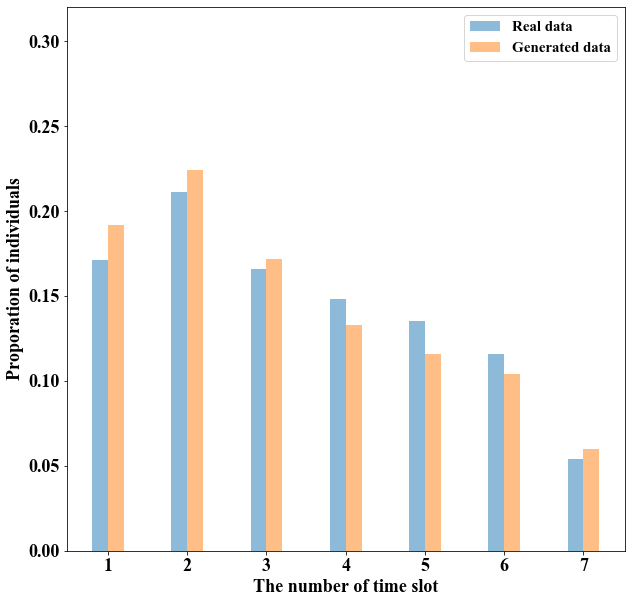

In [68]:
make_plot_sdzh(h_sd_data,g_sd_data)

### 熵的分布对比

In [213]:
trip_df_h

,hphm,riqi,fftime,fpark,tpark,path,route,traveltime
0,鲁R3093998,2019-08-14,17:45,P344,P389,30023-30023,9040-9041-9040,6.00
1,鲁R3093998,2019-08-16,06:30,P389,P134,30023-30069-8788-30068-30067-30171-30170-30032...,9040-9041-8461-9079-9078-9077-9147-9051-9053-9...,31.11
2,鲁R3093998,2019-08-16,08:00,P196,P389,30040-30040-30122-30098-30173-30172-30032-3017...,9063-9062-9063-9102-9103-9148-9053-9051-9147-9...,29.74
3,鲁R3093998,2019-08-16,08:45,P389,P134,30023-30069-8788-30068-30067-30171-30170-30032...,9040-9041-8461-9079-9078-9077-9147-9051-9053-9...,28.45
4,鲁R3093998,2019-08-16,10:00,P196,P389,30040-30040-30122-30098-30173-30172-30032-3017...,9063-9062-9063-9102-9103-9148-9053-9051-9147-9...,26.45
...,...,...,...,...,...,...,...,...
213264,鄂J3589933,2019-08-12,11:45,P111,P111,30182-30181,9155-9156-5100,6.00
213265,鄂J3589933,2019-08-12,13:45,P111,P111,30182-1210,9156-9155-5190,3.52
213266,鄂J3589933,2019-08-12,18:30,P111,P111,30182-30181,9155-9156-5100,6.00
213267,鄂J3589933,2019-08-13,07:15,P111,P46,30182-1210,9156-9155-5190,6.00


In [25]:
def cal_entropy(in_df):
    veh_list = list(set(in_df.hphm))
    E_dict = {}
    num_list = []
    e_list = []
    for v in veh_list:
        sub_df = in_df.query(f"hphm == '{v}'")
        park_dict = dict(Counter(sub_df.tpark))
        park_list = [v for k,v in park_dict.items()]
        num_list.append(sum(park_list))
        park_array = np.asarray(park_list)
        park_array = park_array/sum(park_array)
        log_probs = np.log2(park_array)
        shang = -1*np.sum(park_array*log_probs)
        e_list.append(abs(round(shang,1)))
    E_dict['num'] = num_list
    E_dict['shang'] = e_list
    return E_dict

def shang_process_raw(indi_shang):
    raw_ar = np.zeros([50,50],dtype = int)
    for f,s in zip(indi_shang['num'],indi_shang['shang']):
        if  f <= 45 and s <5:
            fre = int(f)
            shang = 49-int(abs(s)*10)
#             print(fre,shang)
            raw_ar[shang][[fre-1]]+=1
    out_ar = raw_ar/raw_ar.sum(axis = 0)
    out_ar[np.isnan(out_ar)] = 0
    return out_ar


def shang_process(indi_shang):
    raw_ar = np.zeros([40,40],dtype = int)
    for f,s in zip(indi_shang['num'],indi_shang['shang']):
        if  f <= 40 and 1 <= s <5:
            s-=1
            s = round(s,2)
            fre = int(f)
            shang = 39-int(abs(s)*10)
#             print(fre,shang)
            raw_ar[shang][[fre-1]]+=1
    out_ar = raw_ar/raw_ar.sum(axis = 0)
    out_ar[np.isnan(out_ar)] = 0
    return out_ar

def shang_process_gp(indi_shang):
    raw_ar = np.zeros([50,50],dtype = int)
    for f,s in zip(indi_shang['num'],indi_shang['shang']):
        if 41<= f <= 90 and 1< s <6:
            s-=1
            s = round(s,2)
            fre = int(f)
            shang = 49-int(abs(s)*10)
#             print(fre,shang)
            raw_ar[shang][[fre-41]]+=1
    out_ar = raw_ar/raw_ar.sum(axis = 0)
    out_ar[np.isnan(out_ar)] = 0
    return out_ar

In [296]:
shang_g = cal_entropy(trip_df_g)
shang_h = cal_entropy(trip_df_h)

In [297]:
json.dump(shang_h,open("./data/shang_h_glc.json",'w',encoding='utf-8'),ensure_ascii = False)
json.dump(shang_g,open("./data/shang_g_glc.json",'w',encoding='utf-8'),ensure_ascii = False)

In [19]:
print(sum(shang_h['num']))
print(sum(shang_g['num']))

print(sorted(dict(Counter(shang_g['num'])).items(), key=lambda x:x[0]))
print(sorted(dict(Counter(shang_h['num'])).items(), key=lambda x:x[0]))

212935
209042
[(1, 1), (3, 1), (5, 13), (6, 38), (7, 129), (8, 259), (9, 417), (10, 615), (11, 707), (12, 883), (13, 1000), (14, 1169), (15, 913), (16, 804), (17, 763), (18, 691), (19, 601), (20, 513), (21, 539), (22, 376), (23, 349), (24, 282), (25, 228), (26, 219), (27, 179), (28, 141), (29, 125), (30, 113), (31, 94), (32, 73), (33, 73), (34, 39), (35, 41), (36, 24), (37, 13), (38, 11), (39, 5), (40, 7), (41, 5), (42, 1)]
[(1, 50), (2, 92), (3, 80), (4, 116), (5, 160), (6, 229), (7, 266), (8, 381), (9, 398), (10, 552), (11, 506), (12, 677), (13, 688), (14, 882), (15, 768), (16, 772), (17, 648), (18, 592), (19, 520), (20, 467), (21, 461), (22, 375), (23, 326), (24, 275), (25, 279), (26, 240), (27, 191), (28, 196), (29, 177), (30, 139), (31, 131), (32, 114), (33, 97), (34, 77), (35, 65), (36, 68), (37, 51), (38, 50), (39, 31), (40, 43), (41, 31), (42, 27), (43, 17), (44, 17), (45, 4), (46, 8), (47, 8), (48, 6), (49, 7), (50, 3), (51, 2), (52, 1), (54, 2), (55, 1)]


In [81]:
shang_h = json.load(open("./data/shang_h_gp.json"))
shang_g = json.load(open("./data/shang_g_gp.json"))
out_ar_h = shang_process_gp(shang_h)
out_ar_g = shang_process_gp(shang_g)

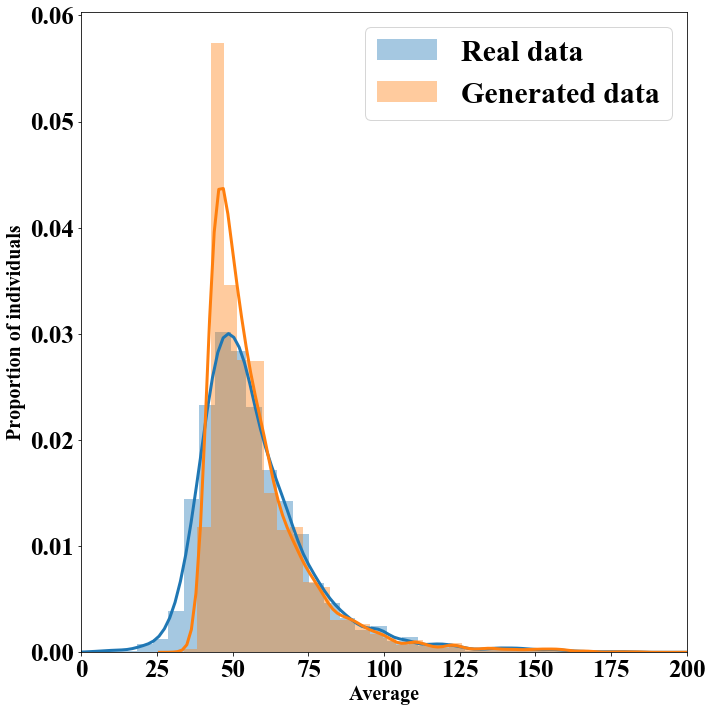

In [400]:
def make_plot_trip_fre():
    plt.figure(figsize=(10,10)) # 设置图片大小

    sns.distplot(list(shang_h['num']), bins=40, \
                    kde_kws={"lw" :3 },label= 'Real data' )

    sns.distplot(list(shang_g['num']), bins=40,\
                    kde_kws={ "lw" :3 }, ax=None, label= 'Generated data')

    ax = plt.gca()
    plt.xlim((0,200))
    plt.xticks(fontproperties = 'Times New Roman',size = 25)
    plt.yticks(fontproperties = 'Times New Roman',size = 25)
    plt.ylabel("Proportion of individuals",fontproperties = 'Times New Roman',size = 20)
    plt.xlabel("Average",fontproperties = 'Times New Roman',size = 20)
    plt.legend(prop=  {'family':'Times New Roman','size':30},loc='best')
    plt.tight_layout()
make_plot_trip_fre()

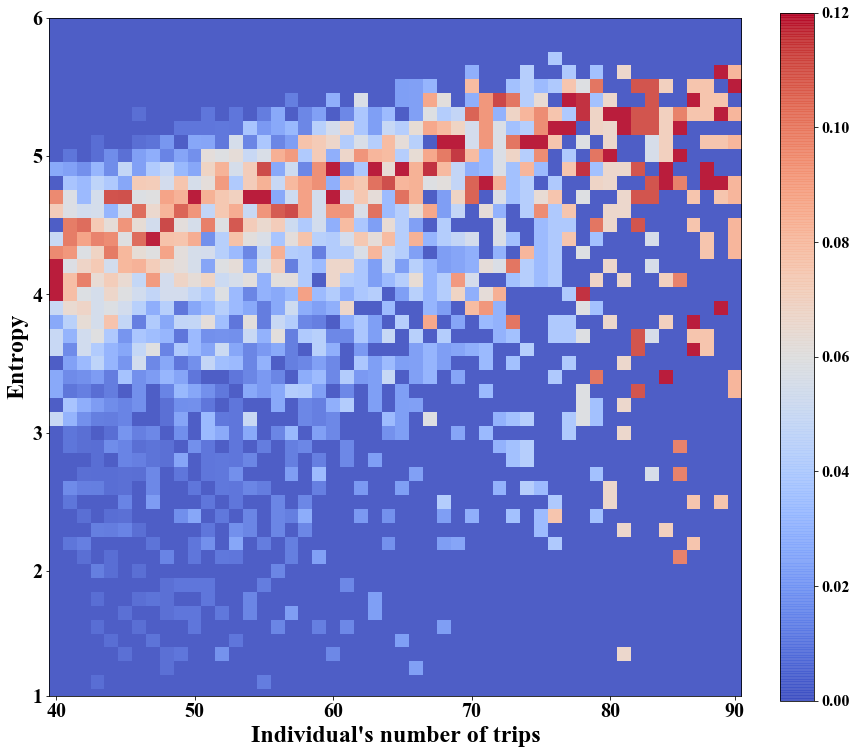

In [83]:
fig2,ax2 = plt.subplots(1,1,figsize=(12,12))                           # 设置画布大小
plt.imshow(out_ar_g, 
           cmap = 'coolwarm',              # 当设置为'auto
           alpha=0.9,
            # 当设置为lower时，热图的左下角为(0,0)
              # vmin和vmax参数用于限定数值的范围，只将vmin和vmax之间的值进行映射
           vmin=0, vmax=0.12)
ax_l = list(np.arange(50))
# plt.xticks([0,10,20,30,40,49],[1,10,20,30,40,50],fontproperties = 'Times New Roman',size = 20)
# plt.yticks([0,10,20,30,40,49],[5,4,3,2,1,0],fontproperties = 'Times New Roman',size = 20)

# plt.xticks([0,10,20,30,39],[1,10,20,30,40],fontproperties = 'Times New Roman',size = 20)
# plt.yticks([0,10,20,30,40],[5,4,3,2,1],fontproperties = 'Times New Roman',size = 20)

plt.xticks([0,10,20,30,40,49],[40,50,60,70,80,90],fontproperties = 'Times New Roman',size = 20)
plt.yticks([0,10,20,30,40,49],[6,5,4,3,2,1],fontproperties = 'Times New Roman',size = 20)


# ax2.axes.yaxis.set_ticks([])
# plt.xlim((-1,49))
cb = plt.colorbar(fraction=0.045,pad=0.05)
cb.ax.tick_params(labelsize=16)
plt.xlabel("Individual's number of trips",fontproperties = 'Times New Roman',size = 24)
plt.ylabel("Entropy",fontproperties = 'Times New Roman',size = 24)
# plt.legend(prop=  {'family':'Times New Roman','size':24})
plt.tight_layout()
plt.savefig("./fig/shang_gp_g.pdf")
plt.show()

### 处理路网文件数据

In [87]:
road_jwd = pd.read_csv("./data/road_guiji_all.csv")
road_center_jwd = pd.read_csv("./data/road_midpoint.csv")

In [45]:
road_jwd = road_jwd.drop_duplicates(subset=['road'])

In [46]:
center_jwd = []
for i in road_jwd.guiji:
    jwd_list = i.split(",")
    len_l = int(len(jwd_list)/2)
    if len_l % 2== 0:
        index = int(len_l/2)
    elif len_l ==1:
        index = 0
    else:
        index =int((len_l-1)/2)
    centerjwd = (jwd_list[2*index],jwd_list[2*index+1])
    center_jwd.append(centerjwd)
        

In [48]:
center_jwd = [(round(float(i)/10000 , 8),round( float(n)/10000, 8)) for i,n in center_jwd]
road_jwd.insert(1,'center_lg',center_jwd) 
road_jwd = road_jwd.set_index('road')
road_center_dict = road_jwd.drop('guiji',axis=1).to_dict()['center_lg']
road_center_dict

In [92]:
# 新的坐标文件
road_center_jwd.objectid = road_center_jwd.objectid.astype(int)
road_center_jwd.objectid = road_center_jwd.objectid.astype(str)

In [97]:
center_lg = []
for x,y in zip(road_center_jwd.x,road_center_jwd.y):
    center_lg.append((x,y))


In [99]:
road_center_jwd.insert(1,'center_lg',center_lg)

In [102]:
road_center_jwd = road_center_jwd.drop(['x','y'],axis=1)

In [108]:
road_center_jwd =  road_center_jwd.set_index('objectid')
road_center_dict = road_center_jwd.to_dict()['center_lg']
road_center_dict

{'1044': (118.767289537275, 30.935276065275374),
 '15363': (118.760945298696, 30.929126830202225),
 '1045': (118.756268489817, 30.934882869828428),
 '1131': (118.762826308573, 30.93179477650703),
 '8008': (118.730230988651, 30.937191171626353),
 '1025': (118.732034599006, 30.94046908786704),
 '1026': (118.735181976961, 30.94225323178545),
 '1027': (118.727773706463, 30.94202879836792),
 '8009': (118.725474069433, 30.939073344643692),
 '15207': (118.72123482501999, 30.94187101530832),
 '15217': (118.7198622926, 30.9437561236612),
 '1028': (118.76750688453001, 30.940963989536638),
 '1029': (118.77922631122802, 30.938177589205473),
 '1030': (118.77544915568599, 30.94233689094242),
 '1031': (118.769457124294, 30.938206829796414),
 '1032': (118.774532441187, 30.93931575418467),
 '1033': (118.77277034299999, 30.936009282500034),
 '1013': (118.7466652125, 30.942781158000056),
 '1011': (118.74969977, 30.942869095),
 '1015': (118.75900888842699, 30.943367421817488),
 '1008': (118.74769192643801

In [112]:
len(road_center_jwd)

484

In [109]:
park_road = pd.read_csv("./data/s_xc_parking_info.csv")[['tccid','roadclid']]

In [113]:
park_road = park_road.drop_duplicates(subset=['roadclid'])
park_road = park_road.query(f"roadclid in {list(road_center_dict.keys())}")

In [115]:
park_road.insert(2,'center_lg',park_road.roadclid.map(lambda x:road_center_dict[str(x)]))

In [76]:
park_road.to_csv("./data/surpport_data.csv",index=False)

In [77]:
all_trip_data = pd.read_csv("./data/raw_data_0801_0902.csv")

In [80]:
sj_veh = list(json.load(open("./data/随机出行者.json",encoding='utf-8')).keys())

In [81]:
all_trip_data1 = all_trip_data.query(f"hphm_new in {sj_veh}")

In [83]:
all_trip_data1.to_csv("./data/sj_trip_raw.csv",index=False)

In [90]:
p = np.array([[1,2],[3,4]])

In [96]:
rand = np.random.RandomState(seed=13)
idx = rand.permutation(10)

In [98]:
dfhis = pd.DataFrame(columns=["epoch",'loss','val_loss'])

In [102]:
dfhis.loc[12] = (1,2,3)

In [103]:
dfhis

,epoch,loss,val_loss
1,1,2,3
12,1,2,3


In [17]:
glc = pd.read_csv("./data/raw_glc.csv")
tq = pd.read_csv("./data/raw_tq.csv")
gp = pd.read_csv("./data/raw_gp.csv")
sj = pd.read_csv("./data/raw_sj.csv")
wd = pd.read_csv("./data/raw_wd.csv")


In [18]:
slx_df = pd.concat([tq,wd,sj,gp,glc],axis=0)

In [20]:
slx_df.to_csv("./data/raw_5leixing.csv",index= False)

In [86]:
dict.fromkeys(['x', 'y', 'x'])

{'x': None, 'y': None}

## 地理图

In [5]:
import geopandas

In [6]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [8]:
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

In [40]:
road = geopandas.read_file("./centerroad/topo_centerroad.shp")
park = geopandas.read_file("./centerroad/park_new.shp")

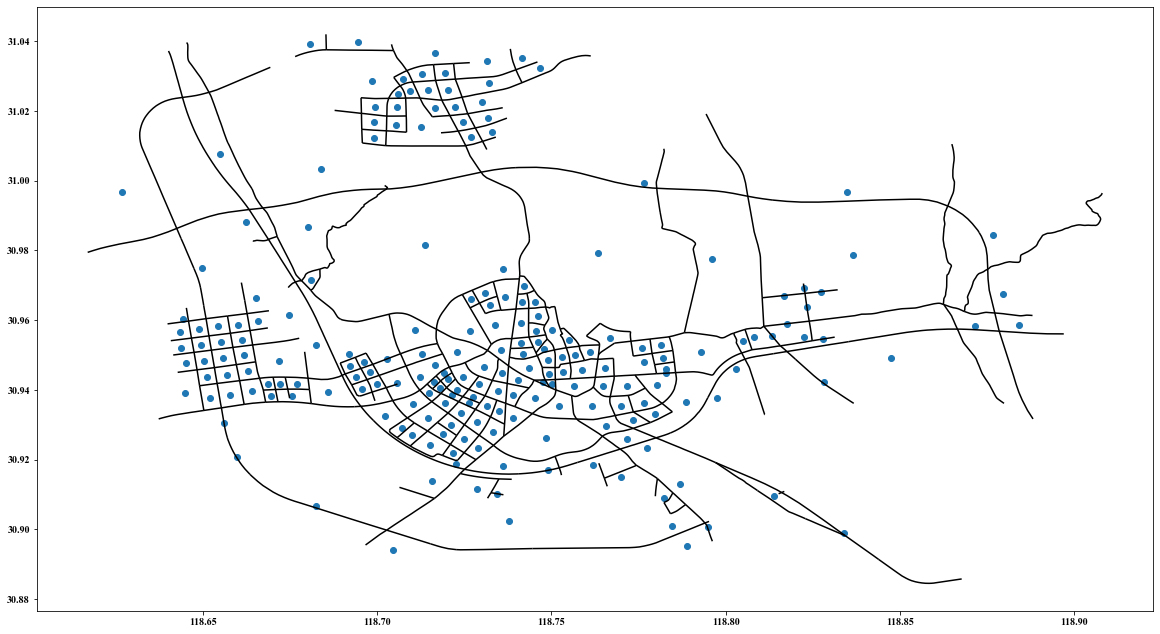

In [42]:
fig,ax = plt.subplots(1,1,figsize = (20,20))
road.plot(ax=ax,color = 'black')
park.plot(ax=ax)

In [29]:
road


,gid,objectid,mc,id,fldm,gbdm,dh,qdz,zdz,lmkd,lmlx,jsdj,gldj,gxsj,f_zlev,t_zlev,oneway,road_level,ft_minutes,tf_minutes,meters,tnode,fnode,fangle,tangle,floor,name,shape_leng,username,edittime,flowdir,admincode,lanenum_sa,lanenum_op,lanenum,fw_start_f,fw_cente_f,fw_end_f,nav_kind,geometry
0,1,1044.0,å¼ æè·¯,71604.0,None,None,None,None,None,0.0,None,None,None,2018-06-27 16:46:09,0,0,None,6,0.0,0.0,629.618421,4634.0,4554.0,336.257837,10.341711,None,å¼ æè·¯,0.000000,admin,2018-06-27 16:46:09,0.0,341800,2.0,2.0,4.0,0.0,0.0,0.0,None,"LINESTRING (118.76830 30.93261, 118.76764 30.9..."
1,2,15363.0,åå±±è·¯,71605.0,None,None,None,None,None,0.0,None,None,None,2018-05-21 12:00:00,0,0,None,6,0.0,0.0,891.738183,4536.0,4497.0,306.552655,317.956293,None,åå±±è·¯,0.000000,admin,2018-05-21 12:00:00,0.0,341800,2.0,2.0,4.0,0.0,0.0,0.0,None,"LINESTRING (118.76463 30.92669, 118.76364 30.9..."
2,3,1045.0,åå±±è·¯,71606.0,None,None,None,None,None,0.0,None,None,None,2018-05-21 12:00:00,0,0,None,6,0.0,0.0,776.293653,4635.0,4536.0,317.956350,356.278301,None,åå±±è·¯,0.000000,admin,2018-05-21 12:00:00,0.0,341800,2.0,2.0,4.0,0.0,0.0,0.0,None,"LINESTRING (118.75730 30.93160, 118.75706 30.9..."
3,4,1131.0,æ°´é³æ±åå¤§é,71607.0,None,None,None,None,None,0.0,None,None,None,2018-06-10 14:48:35,0,0,None,6,0.0,0.0,1068.459582,4554.0,4536.0,92.405366,77.990846,None,æ°´é³æ±åå¤§é,0.000000,admin,2018-06-10 14:48:35,0.0,341800,2.0,2.0,4.0,0.0,0.0,0.0,None,"LINESTRING (118.75730 30.93160, 118.75802 30.9..."
4,5,8008.0,æ¯å¾·è·¯,71608.0,None,None,None,None,None,0.0,None,None,None,2018-05-28 18:33:52,0,0,None,6,0.0,0.0,278.121515,4603.0,4630.0,210.585887,217.480285,None,æ¯å¾·è·¯,278.848246,admin,2018-05-28 18:33:52,0.0,341800,2.0,2.0,4.0,0.0,0.0,0.0,None,"LINESTRING (118.73096 30.93828, 118.73076 30.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,480,1233.0,æ±æè·¯,72087.0,None,None,None,None,None,0.0,None,None,None,2018-05-21 12:00:00,0,0,None,6,0.0,0.0,650.595969,5193.0,9176.0,328.261608,276.267821,None,æ±æè·¯,0.000000,admin,2018-05-21 12:00:00,0.0,341800,2.0,2.0,4.0,0.0,0.0,0.0,None,"LINESTRING (118.74514 30.96850, 118.74445 30.9..."
480,481,30202.0,æ»¨æ¹è·¯,72088.0,None,None,None,None,None,0.0,None,None,None,2018-05-29 11:44:50,0,0,None,6,0.0,0.0,894.987906,4526.0,4497.0,57.514936,74.530523,None,æ»¨æ¹è·¯,888.673729,admin,2018-05-29 11:44:50,0.0,341800,2.0,2.0,4.0,0.0,0.0,0.0,None,"LINESTRING (118.76463 30.92669, 118.76509 30.9..."
481,482,30203.0,æ­äº­åè·¯,72090.0,None,None,None,None,None,0.0,None,None,None,2018-06-29 00:28:28,0,0,None,6,0.0,0.0,561.233236,4671.0,4819.0,184.331446,184.331446,None,æ­äº­åè·¯,1198.994817,laizy,2018-06-29 00:28:28,0.0,None,NaN,NaN,4.0,0.0,0.0,0.0,None,"LINESTRING (118.73772 30.94687, 118.73691 30.9..."
482,483,30204.0,ä¸æ£µæ è·¯,72091.0,None,None,None,None,None,0.0,None,None,None,2018-08-09 15:41:08,0,0,None,6,0.0,0.0,392.232794,9008.0,9006.0,330.605128,335.045424,None,æ¥æ°è·¯,386.864258,chenxy,2018-08-09 15:41:08,0.0,None,NaN,NaN,4.0,0.0,0.0,0.0,None,"LINESTRING (118.69541 30.94611, 118.69465 30.9..."
